In [1]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
data = pd.read_csv("combined.csv")
data['date'] = pd.to_datetime(data['date'])  # Manually convert 'date' to datetime
data.head()



,date,humidity,solar_irradiance,temperature,energy_production
0,2022-01-01,62.483571,519.584526,19.584632,45.939761
1,2022-01-02,59.653418,407.333812,16.585660,51.806938
2,2022-01-03,63.927819,551.165919,19.889962,65.616643
3,2022-01-04,68.648958,345.248763,18.223795,38.991621
4,2022-01-05,60.207166,623.584561,19.291879,60.911264


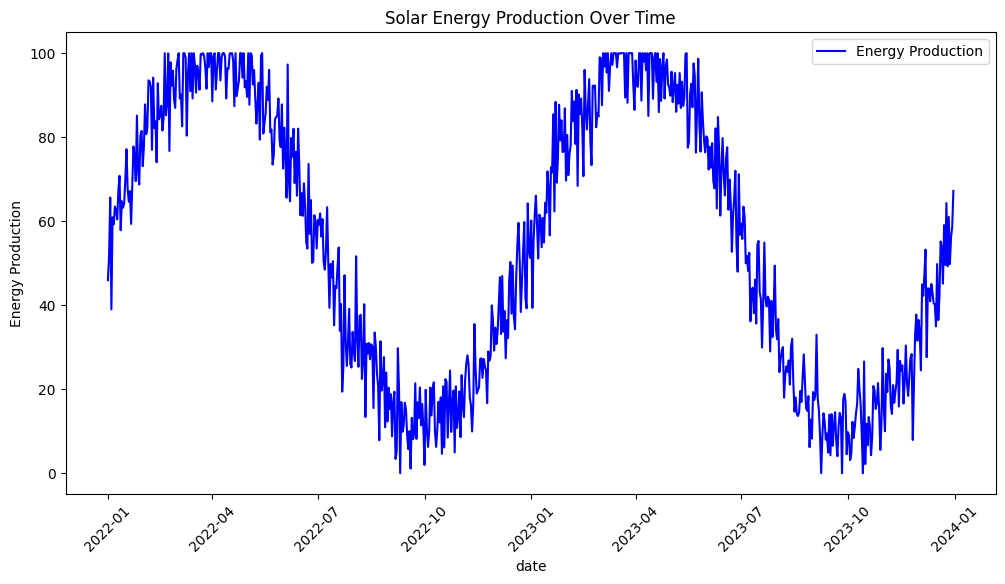

In [2]:
# Plot solar energy production over time
plt.figure(figsize=(12, 6))
plt.plot(data['date'], data['energy_production'], label='Energy Production', color='blue')
plt.title('Solar Energy Production Over Time')
plt.xlabel('date')
plt.ylabel('Energy Production')
plt.legend()
plt.xticks(rotation=45)
plt.show()

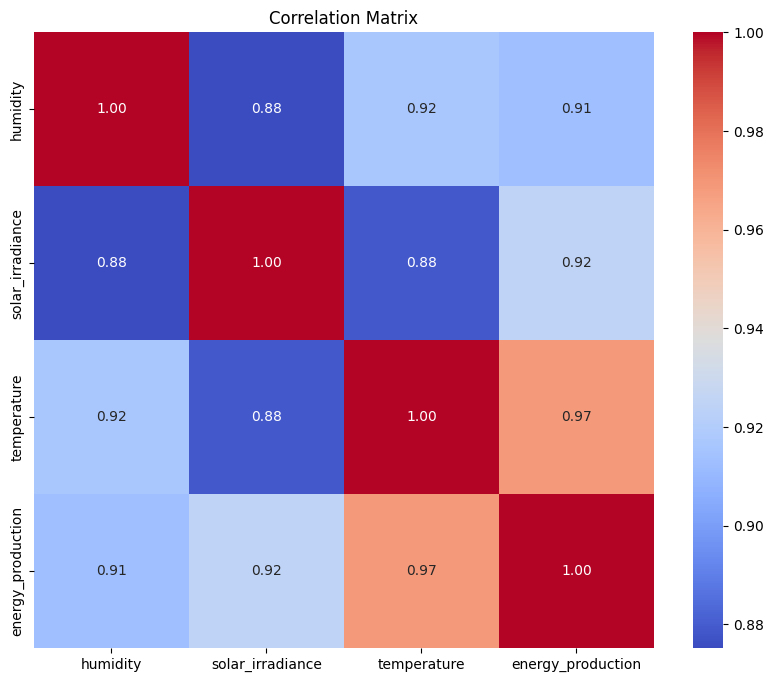

In [3]:
# Filter out non-numeric columns for correlation matrix
numeric_data = data.select_dtypes(include=[np.number])

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

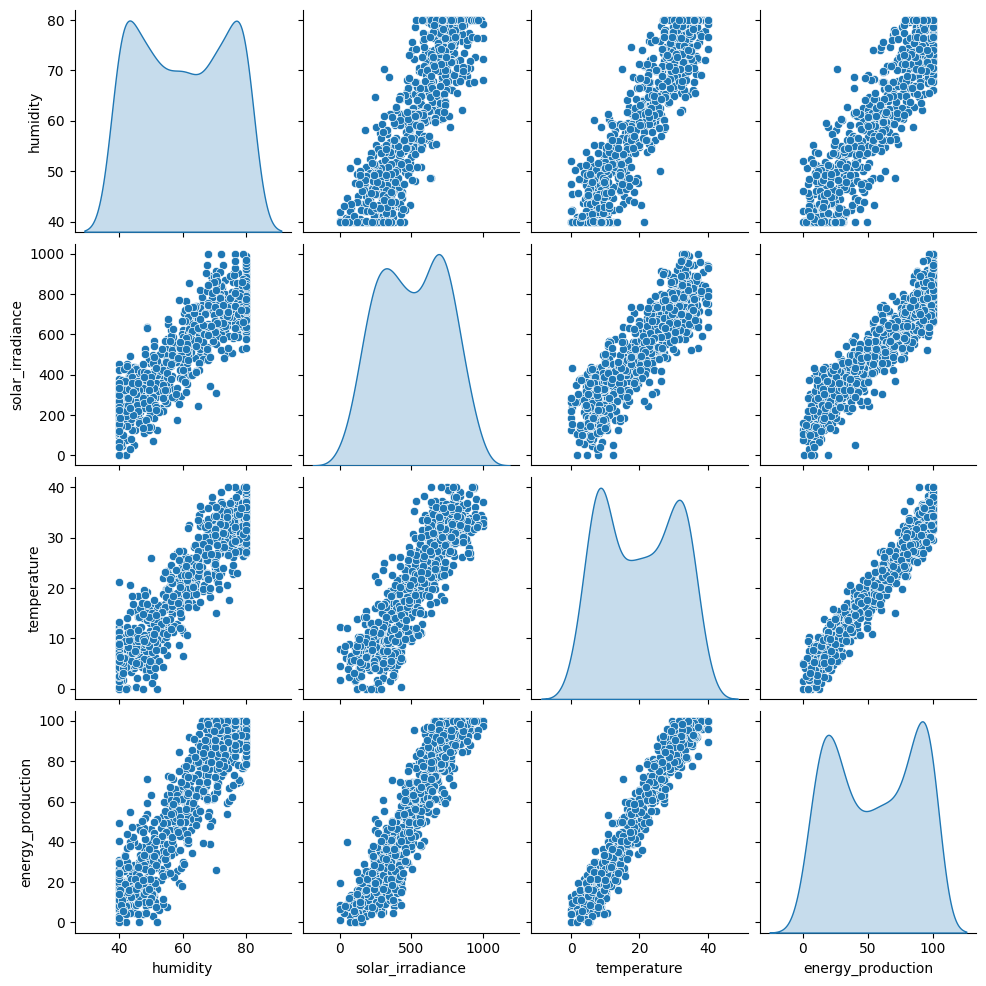

In [4]:

# Plot pairwise relationships between features and target variable
sns.pairplot(data, diag_kind='kde')
plt.show()

In [5]:
# Select the features and target variable
X = data[['humidity', 'solar_irradiance', 'temperature']]
y = data['energy_production']

# Split the data into training and testing sets (shuffle=False for time-series)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Store the test index for later use (before scaling)
test_index = X_test.index

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train the SVR model
svr_model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)  # You can tweak these hyperparameters
svr_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = svr_model.predict(X_test_scaled)

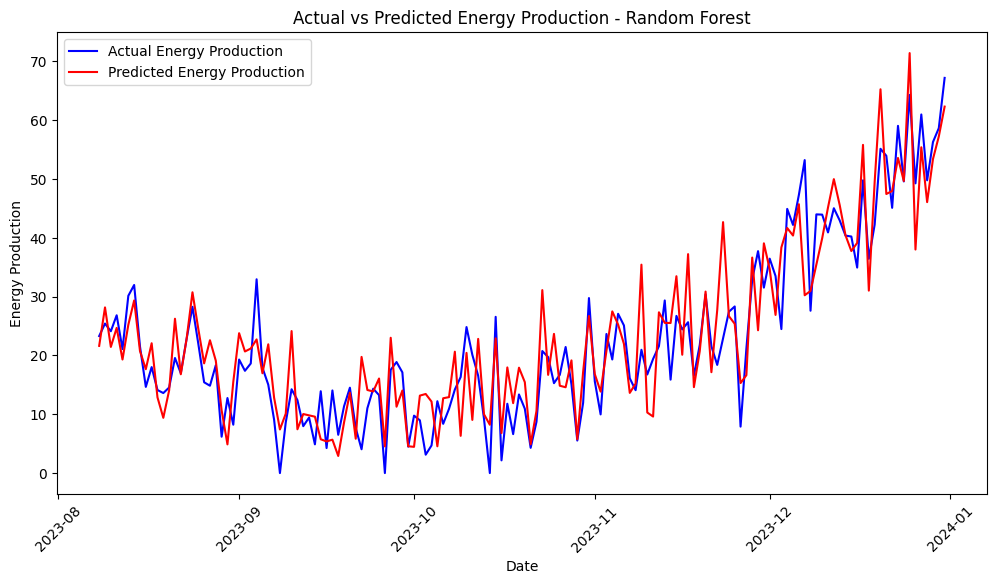

In [6]:
# Merge the test predictions with their corresponding dates
test_results = X_test.copy()
test_results['actual'] = y_test
test_results['predicted'] = y_pred
test_results['date']=data['date']
# Sort by date for proper plotting
test_results = test_results.sort_values(by='date')

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(test_results['date'], test_results['actual'], label='Actual Energy Production', color='blue')
plt.plot(test_results['date'], test_results['predicted'], label='Predicted Energy Production', color='red')
plt.title('Actual vs Predicted Energy Production - Random Forest')
plt.xlabel('Date')
plt.ylabel('Energy Production')
plt.legend()
plt.xticks(rotation=45)
plt.show()

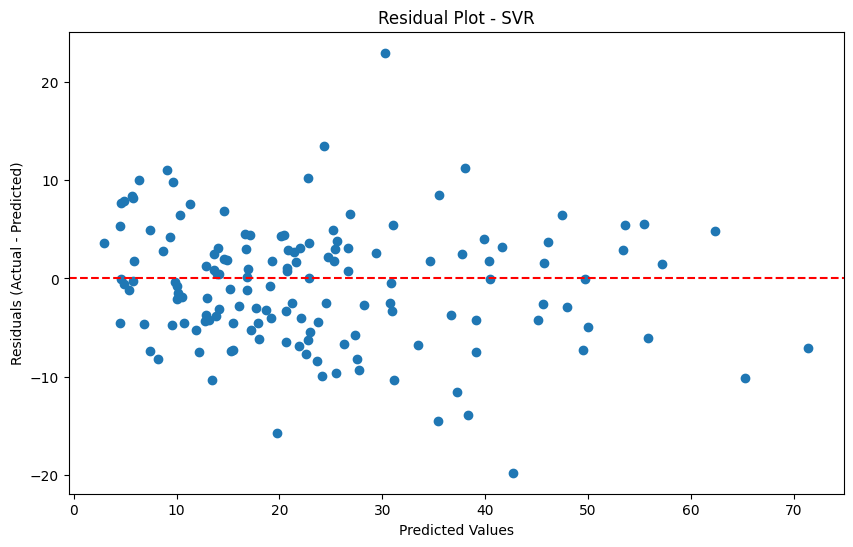

In [7]:
# Plot residuals (Actual - Predicted)
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residual Plot - SVR')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals (Actual - Predicted)')
plt.show()

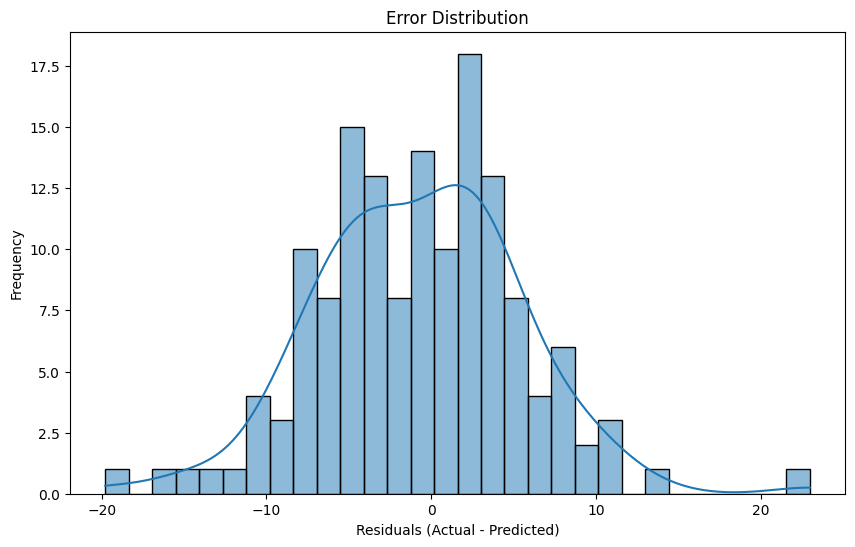

In [8]:
# Plot the error distribution
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.title('Error Distribution')
plt.xlabel('Residuals (Actual - Predicted)')
plt.ylabel('Frequency')
plt.show()

In [9]:

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'R2 Score: {r2}')


MAE: 4.880464732008477
RMSE: 6.188225987454171
R2 Score: 0.8281251887741485


In [10]:
# Calculate accuracy in percentages
accuracy_percentage = r2 * 100
print(f'Accuracy: {accuracy_percentage:.2f}%')

Accuracy: 82.81%
